# Performance Matrix
Compare how different combinations of policies and morphologies perform, to validate that co-training policies and morphologies produces the optimal version for each.

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import gymnasium as gym

from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.vec_env import SubprocVecEnv
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.env_checker import check_env

import Grasper
from Grasper.wrappers import BetterExploration, HandParams, TaskType
from agent import DAPG, PPO_ARGS

# Move up one directory
os.chdir("..")

In [ ]:
def _make_env(env_id, hand_type, task_type):
    env = gym.make(env_id)
    env = HandParams(env, hand_type)
    env = TaskType(env, task_type)
    env = gym.wrappers.FlattenObservation(env)
    env = Monitor(env)
    check_env(env)
    return env

ppo_args = PPO_ARGS.copy()
ppo_args["policy_kwargs"]["task_count"] = 7
ppo_args["verbose"] = 0

## Single-Task Matrices
Generate the matrices for the morphologies trained on single tasks.

In [3]:
scores = np.zeros((7, 6, 6))

for task_type in range(7):
    for hand_type in range(6):
        env = make_vec_env(lambda: _make_env("Grasper/Manipulation-v0", hand_type, task_type), n_envs=24, vec_env_cls=SubprocVecEnv)
        # For each policy
        for policy_idx in range(6):
            policy_path = f"models/hand_type_{policy_idx}_task_{task_type}/ppo_grasper"
            model = DAPG.load(path=policy_path, env=env, **ppo_args)
            # Score each model by running it on the environment
            mean_reward, std_reward = evaluate_policy(model, env, n_eval_episodes=1000, deterministic=True)
            del model
            print(f"Task {task_type}: Hand Type {hand_type} with Policy {policy_idx} scored {mean_reward} +/- {std_reward}")
            scores[task_type, policy_idx, hand_type] = mean_reward
        del env

# Save the scores to a file
np.save("results/scores.npy", scores)

Using cpu device
Loading baseline from models/baseline/baseline_model.pth
Task 0: Hand Type 0 with Policy 0 scored 1052.925290278 +/- 369.1744359848847
Using cpu device
Loading baseline from models/baseline/baseline_model.pth
Task 0: Hand Type 0 with Policy 1 scored 216.380807492 +/- 310.4200861705278
Using cpu device
Loading baseline from models/baseline/baseline_model.pth
Task 0: Hand Type 0 with Policy 2 scored 673.1658658680001 +/- 592.1464219309089
Using cpu device
Loading baseline from models/baseline/baseline_model.pth
Task 0: Hand Type 0 with Policy 3 scored 1043.778276346 +/- 378.8610412873521
Using cpu device
Loading baseline from models/baseline/baseline_model.pth
Task 0: Hand Type 0 with Policy 4 scored 1058.191943859 +/- 357.98482143029236
Using cpu device
Loading baseline from models/baseline/baseline_model.pth
Task 0: Hand Type 0 with Policy 5 scored 1052.3749655450001 +/- 350.4440796568994
Using cpu device
Loading baseline from models/baseline/baseline_model.pth
Task 0:

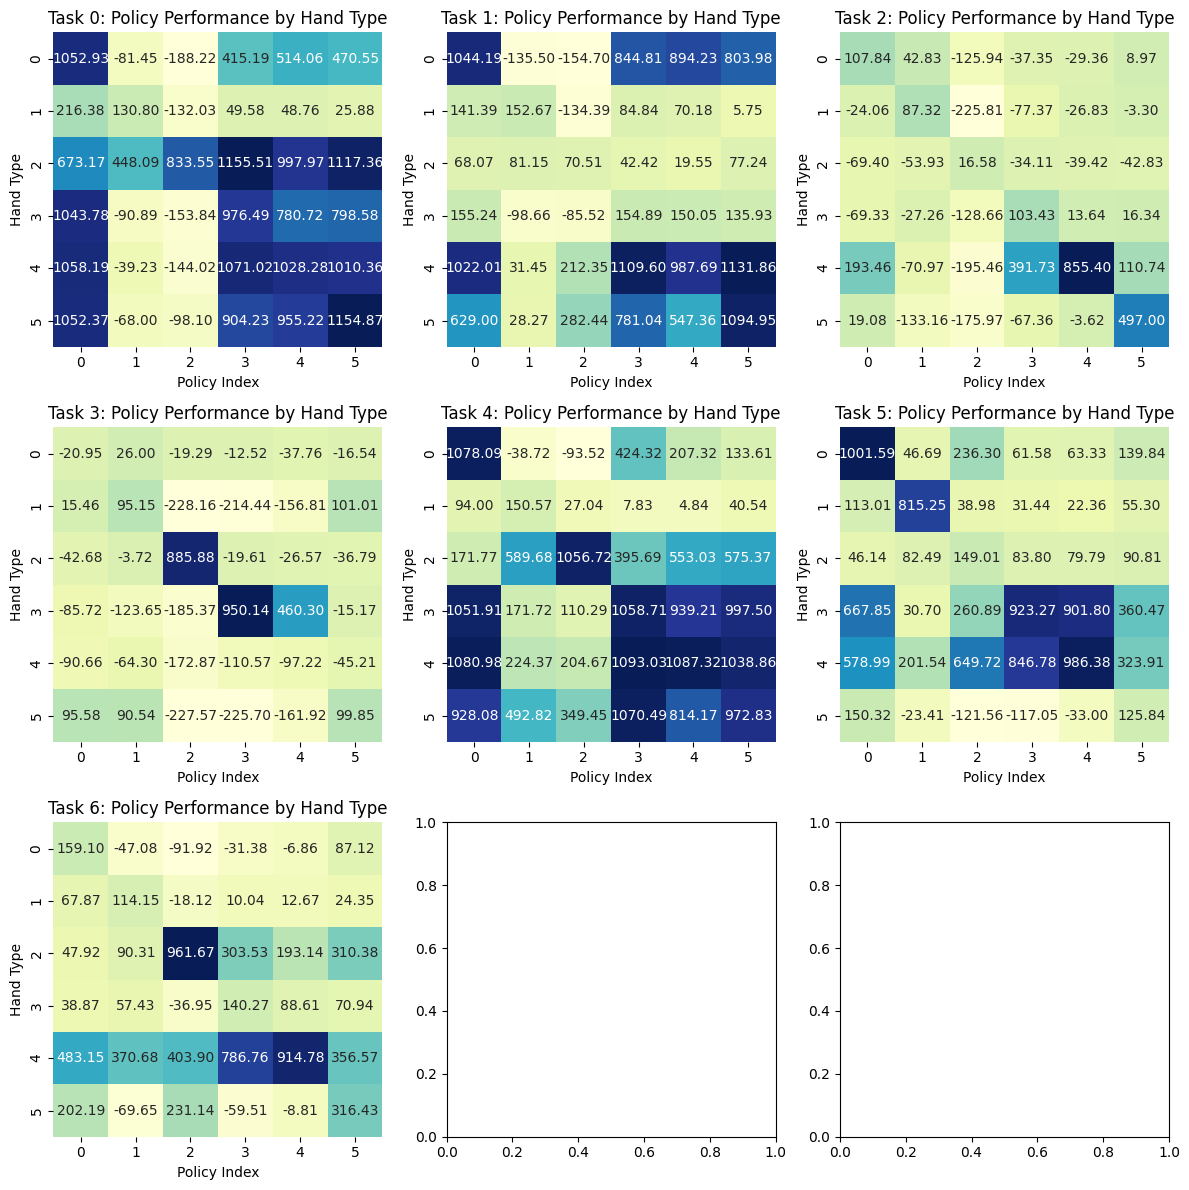

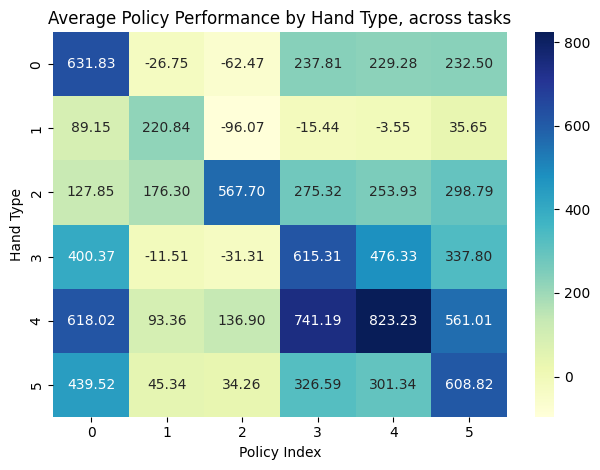

In [4]:
# Generate a heatmap for each task type
fig, axes = plt.subplots(3, 3, figsize=(12, 12))
axes = axes.flatten()
for task_type in range(7):
    ax = axes[task_type]
    sns.heatmap(scores[task_type], annot=True, fmt=".2f", cmap="YlGnBu", cbar=False, ax=ax)
    ax.set_title(f"Task {task_type}: Policy Performance by Hand Type")
    ax.set_xlabel("Policy Index")
    ax.set_ylabel("Hand Type")
    ax.set_xticks(np.arange(6) + 0.5)
    ax.set_xticklabels(np.arange(6))
    ax.set_yticks(np.arange(6) + 0.5)
    ax.set_yticklabels(np.arange(6))
plt.tight_layout()
plt.savefig("diagrams/model_performance_heatmaps.png")
plt.show()

# Make a heatmap of the average performance across all tasks
sns.heatmap(scores.mean(axis=0), annot=True, fmt=".2f", cmap="YlGnBu", cbar=True)
plt.title("Average Policy Performance by Hand Type, across tasks")
plt.xlabel("Policy Index")
plt.ylabel("Hand Type")
plt.xticks(ticks=np.arange(6) + 0.5, labels=np.arange(6))
plt.yticks(ticks=np.arange(6) + 0.5, labels=np.arange(6))
plt.tight_layout()
plt.savefig("diagrams/model_performance_heatmap_avg.png")
plt.show()

## Multi-Task Matrix
Generate a matrix for the morphologies trained on the multi-task environment.

#### Load each policy

#### For each policy, test it with each hand type

In [5]:
scores = np.zeros((6, 6))

# For each hand type
for hand_type in range(6):
    env = make_vec_env(lambda: _make_env("Grasper/Manipulation-v0", hand_type, None), n_envs=24, vec_env_cls=SubprocVecEnv)
    # For each policy
    for policy_idx in range(6):
        policy_path = f"models/hand_type_{policy_idx}_multi/ppo_grasper"
        model = DAPG.load(path=policy_path, env=env, **ppo_args)
        # Score each model by running it on the environment
        mean_reward, std_reward = evaluate_policy(model, env, n_eval_episodes=1000, deterministic=True)
        del model
        print(f"Hand Type {hand_type} with Policy {policy_idx} scored {mean_reward} +/- {std_reward}")
        scores[policy_idx, hand_type] = mean_reward
    del env

FileNotFoundError: [Errno 2] No such file or directory: 'models/hand_type_0_multi/ppo_grasper.zip'

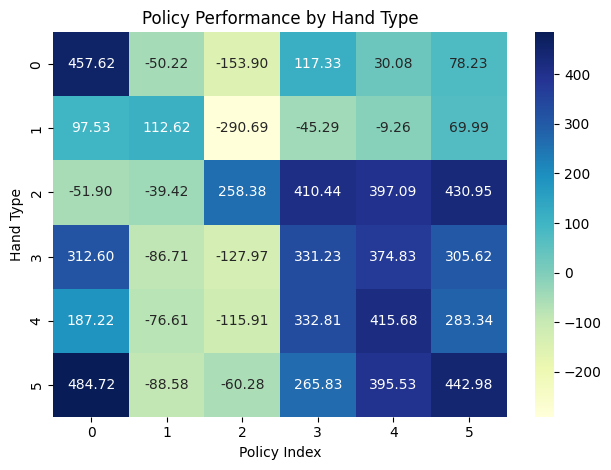

In [ ]:
# Generate a heatmap of the scores
sns.heatmap(scores, annot=True, fmt=".2f", cmap="YlGnBu", cbar=True)
plt.title("Policy Performance by Hand Type")
plt.xlabel("Policy Index")
plt.ylabel("Hand Type")
plt.xticks(ticks=np.arange(6) + 0.5, labels=np.arange(6))
plt.yticks(ticks=np.arange(6) + 0.5, labels=np.arange(6))
plt.tight_layout()
plt.savefig("../diagrams/model_multitask_performance_heatmap.png")
plt.show()